In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
#from datetime import date
#from matplotlib.colors import ListedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import LinearRegression

%run ../global_variables.py ./
%run ../global_functions.py ./

In [2]:
%matplotlib notebook

In [3]:
def seasonal_Fourier_reconstruction(X,Y,P,nP,dP,linear=False):
    if linear: # to be used by TWS where there can be a trend. Trend is suppressed by derivationin TWSC
        # remove the linear trend
        model = LinearRegression()
        model.fit(X.reshape(X.shape[0],1), Y)
        Ydetrend=Y-model.predict(X.reshape(X.shape[0],1))
    else:
        Ydetrend=Y

    # constant term
    a0=np.sum(Ydetrend[0:nP*int(P/dP)]*dP)/(P*nP)
    if linear and np.abs(a0)>1e-8:
        raise Exception("a0 should be 0, it is {:.2e}".format(a0))

    # annual sine wave
    a1=np.sum(Ydetrend[0:nP*int(P/dP)]*np.cos(2*np.pi*X[0:nP*int(P/dP)]/P)*dP)*(2/(P*nP))
    b1=np.sum(Ydetrend[0:nP*int(P/dP)]*np.sin(2*np.pi*X[0:nP*int(P/dP)]/P)*dP)*(2/(P*nP))
    A1=np.sqrt(a1**2+b1**2) # amplitude of the annual signal
    phi1=np.arctan2(b1,a1) # phase of the annual signal

    # semi-annual sine wave
    a2=np.sum(Ydetrend[0:nP*int(P/dP)]*np.cos(4*np.pi*X[0:nP*int(P/dP)]/P)*dP)*(2/(P*nP))
    b2=np.sum(Ydetrend[0:nP*int(P/dP)]*np.sin(4*np.pi*X[0:nP*int(P/dP)]/P)*dP)*(2/(P*nP))
    A2=np.sqrt(a2**2+b2**2)
    phi2=np.arctan2(b2,a2)
    
    print('annual: A={:.1f}, phi={:.1f} \n semi-annual: A={:.1f}, phi={:.1f}'.format(A1,phi1,A2,phi2))

    # sum all components: constant term + annual sine + semi-annual sine (+ linear trend)
    if linear:
        bias=model.intercept_
        trend=model.coef_[0]
        Yrecons=bias+trend*X+A1*np.cos(2*np.pi*X/P-phi1)+A2*np.cos(4*np.pi*X/P-phi2)
        return bias,trend,Yrecons
    else:
        bias=a0
        Yrecons=bias+A1*np.cos(2*np.pi*X/P-phi1)+A2*np.cos(4*np.pi*X/P-phi2)
        return bias,Yrecons

In [14]:
#approximate=True
#basins=load_basins_data(approximate)

In [4]:
basin_name='AMAZON'

data_TWS='GRACE_JPL_mascons'

In [6]:
TWSC_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_idx=pd.date_range('2003-03-01','2014-12-01',freq='SM')[::2]

In [7]:
P=12
nP=time_idx.shape[0]//P
dP=1
X=np.arange(0,time_idx.shape[0],dP)[:nP*P]

annual: A=102.8, phi=-0.9 
 semi-annual: A=11.1, phi=1.5


<IPython.core.display.Javascript object>


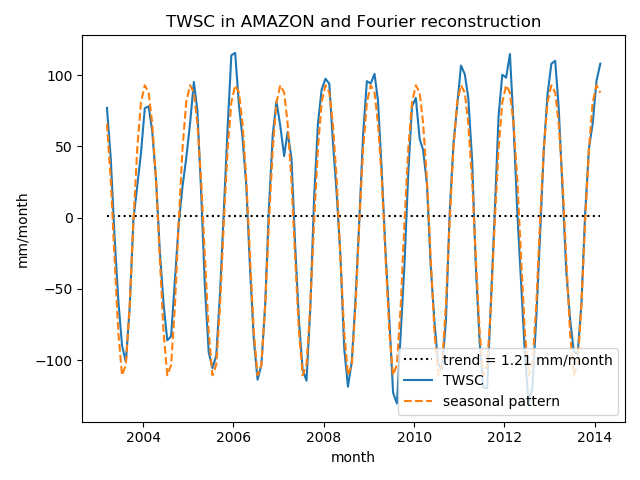

In [8]:
TWSC_filter=TWSC_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]
Y=TWSC_filter.iloc[:nP*P]

bias,Yrecons=seasonal_Fourier_reconstruction(X,Y,P,nP,dP)

plt.figure()
plt.plot(time_idx[:nP*P],bias*np.ones(X.shape[0]),'k:',label='trend = {:.2f} mm/month'.format(bias))
plt.plot(time_idx[:nP*P],Y,label='TWSC')
plt.plot(time_idx[:nP*P],Yrecons,'--',label='seasonal pattern')
plt.xlabel('month')
plt.ylabel('mm/month')
plt.title('TWSC in {} and Fourier reconstruction'.format(basin_name))
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


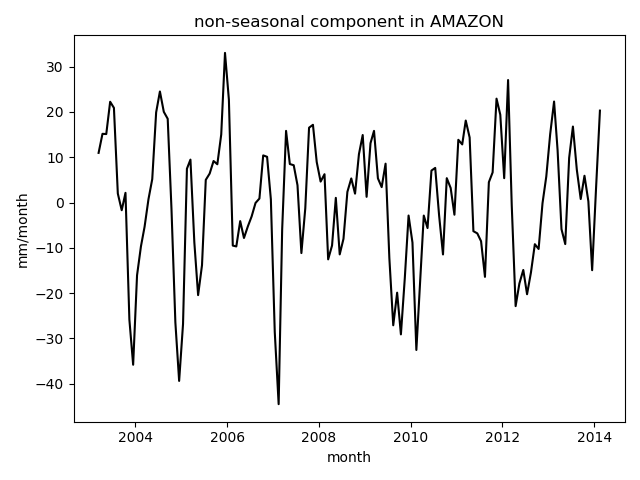

In [9]:
plt.figure()
plt.plot(time_idx[:nP*P],Y-Yrecons,'k')
plt.xlabel('month')
plt.ylabel('mm/month')
plt.title('non-seasonal component in {}'.format(basin_name))
plt.tight_layout()
plt.show()

# budget reconstruction

In [12]:
def get_Afilter(data_P,data_ET,data_R,data_TWS,basin_id):
    TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
    R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
    time_idx=pd.date_range('2003-03-01','2014-12-01',freq='SM')[::2]

    P_filter=P_month.loc[basin_id,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
    ET_filter=ET_month.loc[basin_id,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
    R_filter=R_month.loc[basin_id,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
    TWSC_filter=TWS_month.loc[basin_id,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

    P_filter.index=time_idx
    ET_filter.index=time_idx
    R_filter.index=time_idx
    TWSC_filter.index=time_idx
    
    fillingP=(np.sum(np.isnan(P_filter))==0)
    fillingET=(np.sum(np.isnan(ET_filter))==0)
    fillingR=(np.sum(np.isnan(R_filter))==0)
    fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

    if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
        A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
    else:
        print('This basin is not entirely covered')
    return P_filter,ET_filter,R_filter,TWSC_filter,A_filter

In [13]:
data_P='GPCP'
data_ET='ERA5_Land'
data_R='GRUN'
P_filter,ET_filter,R_filter,TWSC_filter,A_filter=get_Afilter(data_P,data_ET,data_R,data_TWS,basin_name)

annual: A=58.4, phi=-0.9 
 semi-annual: A=0.7, phi=0.8


<IPython.core.display.Javascript object>


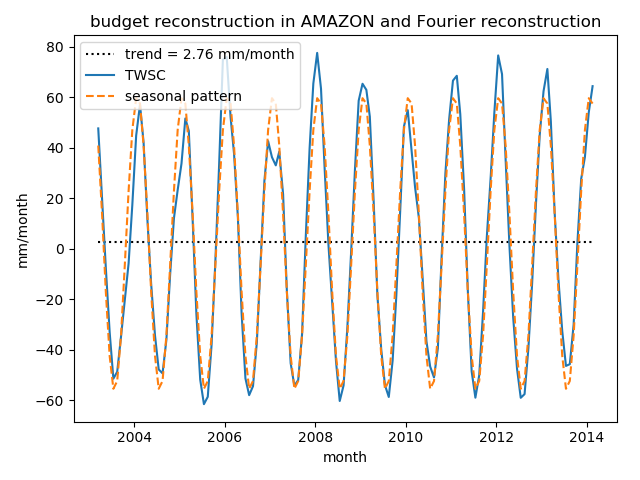

In [14]:
Y=A_filter.iloc[:nP*P]

bias,Yrecons=seasonal_Fourier_reconstruction(X,Y,P,nP,dP)

plt.figure()
plt.plot(time_idx[:nP*P],bias*np.ones(X.shape[0]),'k:',label='trend = {:.2f} mm/month'.format(bias))
plt.plot(time_idx[:nP*P],Y,label='TWSC')
plt.plot(time_idx[:nP*P],Yrecons,'--',label='seasonal pattern')
plt.xlabel('month')
plt.ylabel('mm/month')
plt.title('budget reconstruction in {} and Fourier reconstruction'.format(basin_name))
plt.legend()
plt.tight_layout()
plt.show()